# Data Preprocessing and Transformation

Below, we turn the dataset from a size that we can not manage or process into a managable form. This is done by removing the Date column, reducing the data types to a smaller form, and only using data on Movies and Customers that are frequently rated or rating.

In [66]:
import numpy as np
import pandas as pd
import os
from sklearn.neighbors import NearestNeighbors
from math import sqrt
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [67]:
import os
cwd = os.getcwd()

In [68]:
movie_title = pd.read_csv(cwd + "/movie_titles.csv", encoding='unicode_escape', usecols=[2], header=None)
movie_title.columns = ['title']
movie_title

title
0                                        Dinosaur Planet
1                             Isle of Man TT 2004 Review
2                                              Character
3                           Paula Abdul's Get Up & Dance
4                               The Rise and Fall of ECW
...                                                  ...
17765  Where the Wild Things Are and Other Maurice Se...
17766                  Fidel Castro: American Experience
17767                                              Epoch
17768                                        The Company
17769                                       Alien Hunter

[17770 rows x 1 columns]

In [69]:
movie = pd.read_csv(cwd + "/final.csv")
movie.describe()

MovieID    CustomerID        Rating
count  1.004805e+08  1.004805e+08  1.004805e+08
mean   9.070915e+03  1.322489e+06  3.604290e+00
std    5.131891e+03  7.645368e+05  1.085219e+00
min    1.000000e+00  6.000000e+00  1.000000e+00
25%    4.677000e+03  6.611980e+05  3.000000e+00
50%    9.051000e+03  1.319012e+06  4.000000e+00
75%    1.363500e+04  1.984455e+06  4.000000e+00
max    1.777000e+04  2.649429e+06  5.000000e+00

Here we remove all movies that have been rated fewer than 100 times. Our final dataset needs to be far smaller, so this is an efficient way to only use datapoints that contribute more to the variance of the model.

In [57]:
movie_freq = pd.DataFrame(movie.groupby('MovieID').size(),columns=['count'])
threshold = 100

popular_movies = list(set(movie_freq.query('count>=@threshold').index))

# ratings df after dropping non popular movies
data_popular_movies = movie[movie.MovieID.isin(popular_movies)]

print('shape of original data:', movie.shape)
print('shape of data_popular_movies', data_popular_movies.shape)
print("No. of movies which are rated more than 100 times:", len(popular_movies))

shape of original data: (100480507, 4)
shape of data_popular_movies (100400918, 4)
No. of movies which are rated more than 100 times: 16795


Here we remove all customers that have rated fewer than 1000 times. Our final dataset needs to be far smaller, so this is an efficient way to only use datapoints that contribute more to the variance of the model.

In [58]:
user_freq = pd.DataFrame(movie.groupby('CustomerID').size(),columns=['count'])
# A large number of users are rated very rarely, so we can remove those users which are rated less than 1000 times.
threshold = 900
active_user = list(set(user_freq.query('count>=@threshold').index))
data_popular_movies_active_user = data_popular_movies[data_popular_movies.CustomerID.isin(active_user)]

print('shape of original data:', movie.shape)
print('shape of data_popular_movies', data_popular_movies.shape)
print('shape of data_popular_movies_active_user', data_popular_movies_active_user.shape)
print('No. of users who rated more than 1000 times:', len(active_user))

print('user number of new matrix', len(active_user))
print('movie number of new matrix', len(popular_movies))

shape of original data: (100480507, 4)
shape of data_popular_movies (100400918, 4)
shape of data_popular_movies_active_user (22605955, 4)
No. of users who rated more than 1000 times: 17204
user number of new matrix 17204
movie number of new matrix 16795


## Reducing Size by Data Type

The data is stored in a format of int64 and object type for the date. We don't need the date, so we can drop that column. The other columns we are reducing the data type from int64 to int32 for the CustomerIDs, int64 to int16 for the MovieIDs, and to int8 for the ratings. 

The size of the dataset in MB is printed below, both before and after the changes.

In [59]:
print(data_popular_movies_active_user.memory_usage(), '\n')
print("Memory Usage: ", data_popular_movies_active_user.memory_usage().sum() / (1024**2), " MB")

Index         180847640
MovieID       180847640
CustomerID    180847640
Rating        180847640
Date          180847640
dtype: int64 

Memory Usage:  862.348747253418  MB


In [60]:
data_popular_movies_active_user.dtypes

MovieID        int64
CustomerID     int64
Rating         int64
Date          object
dtype: object

In [61]:
# make a plot of data going down as types are changed and date is removed
memory_usage = []
remainingCols = ['All', 'Mov-Cust-Rate', 'Mov2-Cust-Rate', 'Mov2-Cust2-Rate', 'Mov2-Cust2-Rate2', 'Final']

memory_usage.append(data_popular_movies_active_user.memory_usage().sum() / (1024**2))

reduced_data = data_popular_movies_active_user.drop(columns=['Date'])
memory_usage.append(reduced_data.memory_usage().sum() / (1024**2))

reduced_data['MovieID'] = reduced_data['MovieID'].astype('int16')
memory_usage.append(reduced_data.memory_usage().sum() / (1024**2))

reduced_data['CustomerID'] = reduced_data['CustomerID'].astype('int32')
memory_usage.append(reduced_data.memory_usage().sum() / (1024**2))

reduced_data['Rating'] = reduced_data['Rating'].astype('int8')
memory_usage.append(reduced_data.memory_usage().sum() / (1024**2))

cleanedMovie = reduced_data.iloc[:20000000]
memory_usage.append(cleanedMovie.memory_usage().sum() / (1024**2))

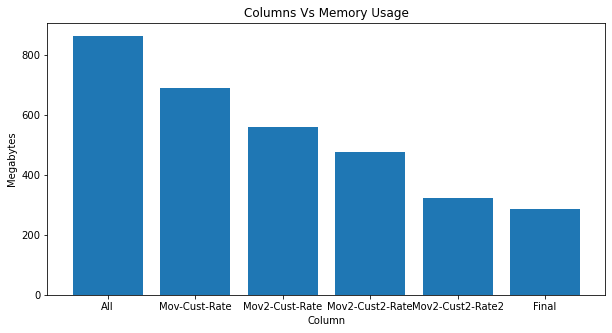

In [62]:
plt.figure(figsize=(10, 5))
plt.bar(remainingCols, memory_usage)
plt.title('Columns Vs Memory Usage')
plt.xlabel('Column')
plt.ylabel('Megabytes')
plt.show()

The chart above shows the reduction in the memory_usage of the data as the changes are made. The data starts at 862.34 MB and ends at 286.1 MB- Practically a third of the original data size!

In [63]:
print("Memory Usage: ", cleanedMovie.memory_usage().sum() / (1024**2), " MB")

Memory Usage:  286.102294921875  MB


In [10]:
cleanedMovie.to_pickle("cleanedMovie.pkl")

In [46]:
cleanedMovie.shape

(18757426, 3)